# Workflow

En esta práctica vamos a aplicar lo aprendido en esta asignatura para crear un flujo que automatice la descarga, análisis y publicación de los datos utilizando distintas herramientas como Zenodo, github y librerías de python para el análisis de datos.

Para ello, utilizaremos la versión de testing de Zenodo (https://sandbox.zenodo.org/) para evitar problemas de baneo de IPs. También, GitHub para almacenar código que ejecutaremos de forma automática.

Antes de empezar, selecciona un dataset sencillo y un script básico que sea capaz de procesar ese dataset. Por ejemplo: Un CSV y un script que haga un plot con los datos y lo guarde como imagen. Puedes coger algo de alguna práctica de otra asignatura.

### Librerías necesarias para la práctica

```python
import xml.etree.ElementTree as ET
import requests
import json
import zipfile
```

### Elementos necesarios
* Al menos un fichero CSV
* Un script de análisis de datos en CSV (Publicado en Github)


# Publicación de datos iniciales

Utilizando Zenodo (https://sandbox.zenodo.org/), de forma manual, publicar los datos que se vayan a utilizar. En la página principal, una vez logueado (te tendrás que registrar, mejor utilizando tu login de GitHub), en el símbolo +, New upload. Rellena los campos y publica.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Utilizar Communities para localizar más facilmente los datos</p>
</div>

Haz un print del DOI que te da al subir el dataset.


# Publicación de script de Análisis

Selecciona el script sencillo de análisis que sea capaz de procesar el dataset que has subido. Guardalo en GitHub.

Desde tu perfil de usuario en Zenodo (SandBox), selecciona la opción GitHub. Si no lo tienes ya, necesitarás conectar tu usuario de GitHub. Desde allí, te indica cómo puedes generar un objeto digital con su DOI de un repositorio de Github. Entre otras cosas, te lleva a crear una "release" de tu código. Una vez está todo, obtendrás un DOI de ese repo. Muéstralo debajo.

# Descarga de datos

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

Pista: url+'?verb=ListRecords&set=nombre_set

In [1]:
import requests
import json
import csv
from datetime import datetime
import xml.etree.cElementTree as ET

Un par de funciones para búsqueda

In [2]:
def search_dataset(url,oai_set,metadata_format):
    """Search the datasets identifiers in the defined set
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        oai_set : string
            OAI-PMH set where the datasets will be searched
        metadata_format : string
            Selected metadata format to search
        Returns
        -------
        dataset_ids : array 
            Dataset IDs
    """
    #Define bounds to search in specific set
    bounds = "&set="+oai_set
    oai = requests.get(url+'?verb=ListRecords&metadataPrefix='+metadata_format+bounds)

    oaiTree = ET.ElementTree(ET.fromstring(oai.text.encode('utf-8')))
    item = oaiTree.findall('.//{http://datacite.org/schema/kernel-3}identifier')
    return item

In [3]:
def get_oai_metadata_formats(url):
    """Lists the available metadata formats
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        Returns
        -------
        metadata_formats : 
            Name of the downloaded file(s).
    """
    metadata_formats = []
    oai_verb = '?verb=ListMetadataFormats'
    oai = requests.get(url + oai_verb) #Peticion al servidor
    xmlTree = ET.ElementTree(ET.fromstring(oai.text))
    iterator = xmlTree.iter()
    for elem in iterator:
        if (elem.tag == '{http://www.openarchives.org/OAI/2.0/}metadataPrefix'):
            metadata_formats.append(elem.text)
    return metadata_formats

In [19]:
def check_dataset(ids,api_url,tipo):
    """Checks if the available datasets satisfy the dates and location req
        Parameters
        ----------
        ids : array
            List of dataset ids
        api_url : string
            API to get dataset metadata
        tipo : string
            type of file to download
        Returns
        -------
        downloaded_datasets : array 
            List of downloaded datasets
    """
    list_of_files = []
    for i in ids:
        print("Checking " + i)
        response = requests.get('https://sandbox.zenodo.org/api/records', params={'q': i.split('.')[-1]})
        url_to_check = response.json()['hits']['hits'][0]['links']['latest']
        headers = {'accept': 'application/json', 'Content-Type': 'application/json'}
        metadata = requests.get(url_to_check, headers=headers)
        for e in metadata.json()['files']:
            print(e)
            if (".%s" % tipo) in e['key']:
                file_name = e['key'].replace('/','_')
                list_of_files.append(file_name)
                link = e['links']['self']
                with open(file_name, "wb") as f:
                    print("Downloading %s" % file_name)
                    response = requests.get(link, stream=True)
                    total_length = response.headers.get('content-length')
                    if total_length is None: # no content length header
                        f.write(response.content)
                    else:
                        dl = 0
                        total_length = int(total_length)
                        for data in response.iter_content(chunk_size=4096):
                            dl += len(data)
                            f.write(data)
                            done = int(50 * dl / total_length)
                            sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                            sys.stdout.flush()
      
    return list_of_files

Busco el dataset y el código publicado. Si no lo localizas con OAI-PMH, puedes introducir directamente los DOIs.

In [21]:
import sys
#Searching datasets OAI-PMH
print("Searching datasets OAI-PMH")
oai_url = 'https://sandbox.zenodo.org/oai2d'
metadata_formats = get_oai_metadata_formats(oai_url)

#TODO hardcoded
print("Searching Datasets")
oai_set = 'user-cdp'
dataset_list = search_dataset(oai_url,oai_set,'oai_datacite3')
print(dataset_list)

print("Checking/download Datasets")
api_url = 'https://sandbox.zenodo.org/'

dataset_list = ["10.5072/zenodo.23572", "10.5072/zenodo.23574"] #Esto lo tienes que cambiar ;)

csv_files = check_dataset(dataset_list,api_url,'csv')
print(csv_files)

zip_files = check_dataset(dataset_list,api_url,'zip')
print(zip_files)

Searching datasets OAI-PMH
Searching Datasets
[]
Checking/download Datasets
Checking 10.5072/zenodo.23572
{'id': '81667ca6-ded1-45bc-80f3-0be640bd1281', 'key': 'amt_2010.csv', 'size': 4275737, 'checksum': 'md5:f38ded28383d9f69af7cb9c98aed798b', 'links': {'self': 'https://sandbox.zenodo.org/api/records/23572/files/amt_2010.csv/content'}}
Checking 10.5072/zenodo.23574
{'id': '10b037eb-7ffe-496c-b634-1542d44a342a', 'key': 'ferag/dlc_metadata_2023-t1.zip', 'size': 5784, 'checksum': 'md5:8f54483a372e6bc2abf82ec77c437f12', 'links': {'self': 'https://sandbox.zenodo.org/api/records/23574/files/ferag/dlc_metadata_2023-t1.zip/content'}}
['amt_2010.csv']
Checking 10.5072/zenodo.23572
{'id': '81667ca6-ded1-45bc-80f3-0be640bd1281', 'key': 'amt_2010.csv', 'size': 4275737, 'checksum': 'md5:f38ded28383d9f69af7cb9c98aed798b', 'links': {'self': 'https://sandbox.zenodo.org/api/records/23572/files/amt_2010.csv/content'}}
Checking 10.5072/zenodo.23574
{'id': '10b037eb-7ffe-496c-b634-1542d44a342a', 'key': '

Descomprime el código, que viene en un zip (tienes que cambiar los nombres)

In [56]:
import zipfile
import os
with zipfile.ZipFile("ferag_csvprinter-1.02.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
os.system("mv ./ferag-csvprinter-59552e7/* .")

0

Haz algo con el dataset, mostrarlo de algún modo.

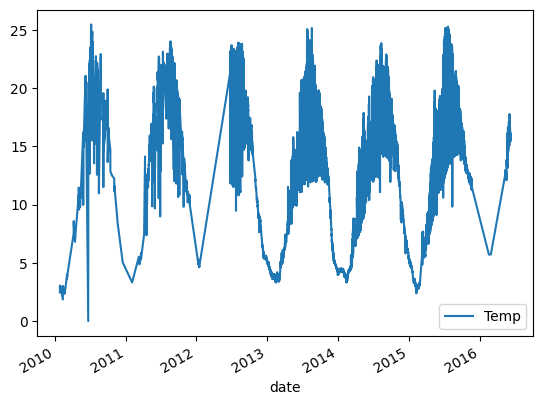

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('amt_2010.csv',delimiter=';')
data['date'] = pd.to_datetime(data['date'])
data.plot(x='date', y='Temp')
plt.show()

Number of arguments: 2 arguments
Argument List:['plot.py', 'amt_2010.csv']


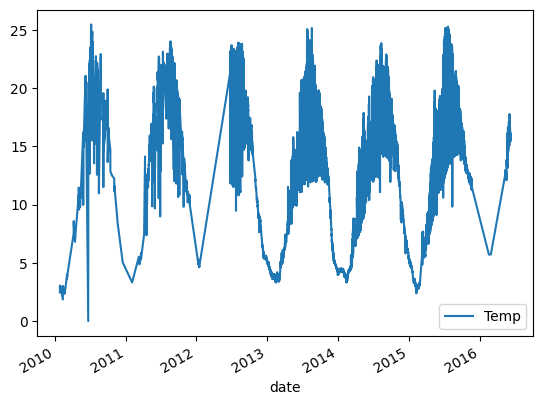

In [58]:
%run -i plot.py amt_2010.csv

In [59]:
ls

amt_2010.csv               GuionPractica_Zenodo.ipynb        README.md
ferag_csvprinter-1.02.zip  M3.02Workflow_resuelto2023.ipynb
ferag-csvprinter-59552e7/  plot.py


# Publicación de los Datos

Utilizando la API de Zenodo SandBox, necesitarás un access token que te permita hacer la publicación. Echa un vistazo a la documentación para ver cómo se consigue. Es fácil...
Después, modifica este código para crear un nuevo depósito con el resultado generado (una imagen, un dataset derivado, un texto con el print de los datos...)

In [66]:
ACCESS_TOKEN = 'deXgWpfrLUvl87UGdzWt0UPsipKqiBkevYIG6OGihQ5'
r = requests.get('https://sandbox.zenodo.org/api/deposit/depositions',params={'access_token': ACCESS_TOKEN})
r.status_code
r.json()


[{'conceptdoi': '10.5072/zenodo.1150229',
  'conceptrecid': '1150229',
  'created': '2023-01-23T08:03:50.668985',
  'doi': '10.5072/zenodo.1150230',
  'doi_url': 'https://doi.org/10.5072/zenodo.1150230',
  'files': [{'checksum': 'bd2f87e15ac7111513df3142f001add9',
    'filename': 'ferag/csvprinter-1.02.zip',
    'filesize': 740,
    'id': '57ed82c7-b4a3-49ee-88d6-86debcae0fc5',
    'links': {'download': 'https://sandbox.zenodo.org/api/files/45496d02-c7de-4c24-ab72-b8491a29b28f/ferag/csvprinter-1.02.zip',
     'self': 'https://sandbox.zenodo.org/api/deposit/depositions/1150230/files/57ed82c7-b4a3-49ee-88d6-86debcae0fc5'}}],
  'id': 1150230,
  'links': {'badge': 'https://sandbox.zenodo.org/badge/doi/10.5072/zenodo.1150230.svg',
   'bucket': 'https://sandbox.zenodo.org/api/files/b0270ae7-16f1-4675-a5d6-d7fa90b3b21d',
   'conceptbadge': 'https://sandbox.zenodo.org/badge/doi/10.5072/zenodo.1150229.svg',
   'conceptdoi': 'https://doi.org/10.5072/zenodo.1150229',
   'discard': 'https://sandbo

En la celda de abajo, tendrás que modificar cosas como el deposition_id (es un id que te dan al hacer el paso anterior, el nombre del fichero...). Echa un vistazo a la documentación, por si falta algo ;)

In [68]:
deposition_id = "1150228"
data = {'name': 'electricom.png'}
files = {'file': open('plot.py', 'rb')}
r = requests.post('https://sandbox.zenodo.org/api/deposit/depositions/%s/files' % deposition_id,
                  params={'access_token': ACCESS_TOKEN}, data=data,
                  files=files)
r.status_code

403

In [ ]:
data = {
    'metadata': {
        'title': 'My first upload',
        'upload_type': 'poster',
        'description': 'This is my first upload',
        'creators': [{'name': 'Doe, John',
                      'affiliation': 'CSIC'}]
    }
}
r = requests.put('https://sandbox.zenodo.org/api/deposit/depositions/%s' % deposition_id,
                 params={'access_token': ACCESS_TOKEN}, data=json.dumps(data),
                 headers=headers)
r.status_code
r.json()

Una vez has publicado el resultado, recibirás un DOI. Muestralo en la última celda: